## Pothole detection

Jacek Piszczek
Damodar Łepski


(38400,)


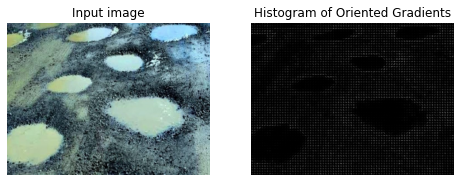

In [12]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from skimage.io import imread
from skimage.transform import resize

image = imread('Pothole_Image_Data/16.jpg')
image = resize(image, (480, 640))

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

print(fd.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 5))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()